# Create Subpods
____
This script uses uproot.lazy to read the data and event trees from 100 files in only 2 seconds!\
This applies the necessary cuts to select "subpods" (pods sliced to remove the tails)\
These cuts include: an area cut to select SPEs, a time cut to select LED-coincident SPEs\
Output: 1 pickle file per channel in run{runs}data which contains all subpods for that channel + event number + time of SPE wrt zero\
This script takes a while to run because we are looking at A LOT of pods. This whole process needs to be done about once a month so this is not a big issue.\
Furthermore, the RAM usage is TINY in comparison to the usual "read a file, fill df, write to file" method
_____

In [2]:
import numpy as np
import pandas as pd
import os 
import matplotlib
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import utils
import tqdm
import uproot
import numba
from scipy.optimize import curve_fit
from matplotlib.colors import LogNorm
import scipy
import awkward as ak
import time

Read the ROOT files
________

Top array LEDs seem to produce a lot more stats, use 1/5th the number of files for run 7264

In [5]:
prefix='/global/cfs/cdirs/lz/data/raw/SR1/'
runs=[7491]
filepaths = utils.get_file_paths(prefix, runs) 
datas=[]
for i in range(len(filepaths)):
    data = uproot.lazy(
        # list of files; local files can have wildcards (*)
        filepaths[i]+":Data",
        # TTree name in each file
        # branch(s) in each file for lazyarray(s)
       ["zData","startTime","channel"])
    datas.append(data)
print(len(datas))

100


In [6]:
print(len(filepaths))
data_all = uproot.lazy(
    # list of files; local files can have wildcards (*)
    [x+str(":Data") for x in filepaths],
    # TTree name in each file
    # branch(s) in each file for lazyarray(s)
   ["zData","startTime","channel"])

100


In [7]:
event = uproot.lazy( 
    # list of files; local files can have wildcards (*)
    [x+str(":Event") for x in filepaths],
    # TTree name in each file
    # branch(s) in each file for lazyarray(s)
   ['trgTimeStamp','firstData'])

In [8]:
def chunks(lst, n):
    """Yield successive n-sized chunks from lst."""
    for i in range(0, len(lst), n):
        yield lst[i:i + n]
event_pods = list(chunks(event.firstData, 5000)) ###5000 is the number of events per file
event_trgtimes = list(chunks(event.trgTimeStamp, 5000)) # len=20

In [9]:
numpods = sum([len(x.zData) for x in datas])
print(numpods)

35939033


Define event number and flatten event variables\
combines pods into events. This is why we needed to keep the data tree separate for each file
__________

In [10]:
test,tempadd,accumulation = 0,0,0
eventnumber_all,trigtimes_all,podids=[],[],[]
eventnumber = np.zeros(numpods)
trigtimes = np.zeros(numpods)
starttimes_rel_trigger = np.zeros(numpods)
for i in tqdm.tqdm(range(len(event_pods))):
    new = ak.to_list(event_pods[i])
    num_waveforms = len(datas[i].zData) 
    new.append(num_waveforms) 
    new = np.array(new) 
    new+=accumulation 
    accumulation+=num_waveforms 
    podids.append(new)
    ### event variables --> match pod dimensions
    for j in range(len(new)-1):
        eventnumber[new[j]:new[j+1]] = j+1+tempadd ### +1 so we dont count from 0. Need to accumulate between files so + tempadd
        trigtimes[new[j]:new[j+1]] = event_trgtimes[i][j]
    tempadd += 1000

100%|██████████| 100/100 [03:46<00:00,  2.26s/it]


make sure number of pods is consistent

In [13]:
assert(podids[-1][-1] == sum([len(x.zData) for x in datas]))

In [14]:
print(podids[-1][-1])
print(sum([len(x.zData) for x in datas]))

35939033
35939033


making event variables = pod variable lengths

In [15]:
assert(len(eventnumber) == len(trigtimes) == podids[-1][-1])

check we have 1 event per trigger

In [16]:
trigger_mask = [x.channel == 2101 for x in datas]

In [17]:
trigger_mask = ak.ravel(np.concatenate(trigger_mask))

In [18]:
assert(len(eventnumber[trigger_mask]) == 5000*len(filepaths))

In [19]:
np.count_nonzero(trigger_mask) ##should = 5000 * numfiles

500000

subpod method
____

In [20]:
starttimereltrigger = data_all.startTime - trigtimes

In [21]:
channelALL = data_all.channel

### time histogram

In [22]:
tpc_pmts = utils.get_channel_IDs("TTPC")
Tpc_strt = []
for i in range(len(tpc_pmts)):
    t_channel = tpc_pmts[i]
    channel_mask = channelALL == t_channel
    channel_starttimereltrigger = starttimereltrigger[channel_mask]
    Tpc_strt.append(channel_starttimereltrigger)
Tpc_strt_ = [item for sublist in Tpc_strt for item in sublist]

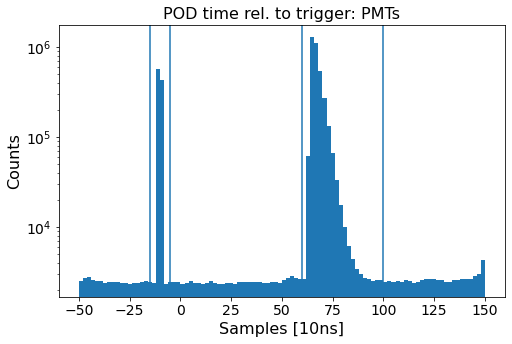

In [24]:
plt.figure(figsize=(8,5))
plt.hist(starttimereltrigger, bins=100,range=[-50,150])
plt.yscale('log')
plt.axvline(-15)
plt.axvline(-5)
plt.axvline(60)
plt.axvline(100)
plt.title('POD time rel. to trigger: PMTs',fontsize=16)
plt.xlabel('Samples [10ns]',fontsize=16)
plt.ylabel('Counts',fontsize=16)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.show()

In [25]:
### mask by time rel trigger
timereltrigger_mask = ((starttimereltrigger > 60) & (starttimereltrigger < 100)) | ((starttimereltrigger > -15) & (starttimereltrigger < -5))

In [27]:
print(f"reduction from {len(data_all.zData)} events to {np.count_nonzero(timereltrigger_mask)}")

reduction from 35939033 events to 4580643


In [28]:
zData_ = data_all.zData[timereltrigger_mask] * 1 #times by 1 to evaluate all elements
starttimereltrigger_ = starttimereltrigger[timereltrigger_mask]
eventnumber_ = eventnumber[timereltrigger_mask]
trigtimes_ = trigtimes[timereltrigger_mask]
channel_ = data_all.channel[timereltrigger_mask]

In [30]:
pmts = utils.get_channel_IDs("TTPC")
pmts.append(2101)
print(pmts)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221,

Get subpods for all channels \
Make sure you have a folder called f"run{runs}data"\
Overall ETA = 1.5 hours.
____

In [27]:
for i in tqdm.tqdm(range(len(pmts))):
    t_channel = pmts[i]
    channel_mask = channel_ == t_channel
    channel_eventnumber = eventnumber_[channel_mask]   
    if(len(channel_eventnumber)>10000 and t_channel<2000): # input 10000 PODs for each channel
        channel_eventnumber = channel_eventnumber[:10000]
        channel_zData = zData_[channel_mask][:10000]
        channel_starttimereltrigger = starttimereltrigger_[channel_mask][:10000]
        channel_trigtimes = trigtimes_[channel_mask][:10000]
        channel_channel = channel_[channel_mask][:10000]
    else:
        channel_zData = zData_[channel_mask] #times by 1 to evaluate all elements (need to test speed=3.5min? + memory=5GB) only do this when you need to operate on the arrays
        channel_starttimereltrigger = starttimereltrigger_[channel_mask]
        channel_trigtimes = trigtimes_[channel_mask]
        channel_channel = channel_[channel_mask]
    ### area and peak for this channel
    if t_channel < 2101:
        areas = list(map(utils.findPODArea, -1*channel_zData)) # input all PODs for this channel
        area = [areas[i][0] for i in range(len(areas))]
        peaks = [areas[i][1] for i in range(len(areas))] # peaks for all PODs in this channel
        realistic_area = [area[i] for i in range(len(area)) if area[i] < 1000]
        realistic_peak = [peaks[i] for i in range(len(peaks)) if area[i] < 1000]
        mean_area = np.mean(realistic_area)
        stdev_area = np.std(realistic_area)
        min_area = mean_area - stdev_area
        max_area = mean_area + stdev_area
    sub_pods,final_event_numbers,pod_time=[],[],[]
    if len(channel_zData)==0:
        print("bad channel=",t_channel)
        continue 
    for j in range(len(channel_zData)):  # j go through zData array for that channel for every event 
        baselinesub_pod = -1*channel_zData[j] - np.mean(-1*channel_zData[j][0:20]) # invertion and baseline subtraction
        if t_channel < 2101:
            if (area[j] == -1) or (area[j] < min_area) or (area[j] > max_area):
                continue
            sub_pod_peak_time = 10
            sub_pod = baselinesub_pod[peaks[j][0] - sub_pod_peak_time:peaks[j][0] + 15]
            pod_subpod_diff   = peaks[j][0] - sub_pod_peak_time ## original peak position - new peak position = number of start samples cut off
            sub_pod_rel_event = channel_starttimereltrigger[j] + pod_subpod_diff
        elif t_channel >= 2101:
            sub_pod_peak_time = 20
            ### define the NIM time as 90% of maximum
            time_at_this = 0.9*np.max(baselinesub_pod)
            point_90p = np.argmax(baselinesub_pod>time_at_this)  ## return the first sample larger than 0.9*max
            sub_pod = baselinesub_pod[point_90p - sub_pod_peak_time:point_90p + 30]
            pod_subpod_diff   = point_90p - sub_pod_peak_time ## original peak position - new peak position = number of start samples cut off
            sub_pod_rel_event = channel_starttimereltrigger[j] + pod_subpod_diff
        final_event_numbers.append(channel_eventnumber[j])
        sub_pods.append(sub_pod)
        pod_time.append(sub_pod_rel_event)
    
    #print(t_channel,len(sub_pods))
    df=pd.DataFrame(zip(final_event_numbers,sub_pods,pod_time),columns=['eventnumber','subpods','podtime'])
    df.to_pickle(f'/global/cfs/cdirs/lz/users/yqie/PMT-ANALYSIS/TimingStudies/run{runs}data/channel_{t_channel}_subpods.pkl')
    del df

 12%|█▏        | 30/254 [08:35<1:10:10, 18.80s/it]/global/homes/y/yufanqie/.conda/envs/pmtStudies/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/global/homes/y/yufanqie/.conda/envs/pmtStudies/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/global/homes/y/yufanqie/.conda/envs/pmtStudies/lib/python3.8/site-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/global/homes/y/yufanqie/.conda/envs/pmtStudies/lib/python3.8/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/global/homes/y/yufanqie/.conda/envs/pmtStudies/lib/python3.8/site-packages/numpy/core/_methods.py:254: Ru

bad channel= 30


 49%|████▉     | 124/254 [35:44<35:21, 16.32s/it] /global/homes/y/yufanqie/.conda/envs/pmtStudies/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/global/homes/y/yufanqie/.conda/envs/pmtStudies/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/global/homes/y/yufanqie/.conda/envs/pmtStudies/lib/python3.8/site-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/global/homes/y/yufanqie/.conda/envs/pmtStudies/lib/python3.8/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/global/homes/y/yufanqie/.conda/envs/pmtStudies/lib/python3.8/site-packages/numpy/core/_methods.py:254: Ru

bad channel= 124


 56%|█████▌    | 142/254 [40:23<34:10, 18.30s/it]/global/homes/y/yufanqie/.conda/envs/pmtStudies/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/global/homes/y/yufanqie/.conda/envs/pmtStudies/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/global/homes/y/yufanqie/.conda/envs/pmtStudies/lib/python3.8/site-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/global/homes/y/yufanqie/.conda/envs/pmtStudies/lib/python3.8/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/global/homes/y/yufanqie/.conda/envs/pmtStudies/lib/python3.8/site-packages/numpy/core/_methods.py:254: Run

bad channel= 142


 73%|███████▎  | 186/254 [51:40<15:41, 13.84s/it]/global/homes/y/yufanqie/.conda/envs/pmtStudies/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/global/homes/y/yufanqie/.conda/envs/pmtStudies/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/global/homes/y/yufanqie/.conda/envs/pmtStudies/lib/python3.8/site-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/global/homes/y/yufanqie/.conda/envs/pmtStudies/lib/python3.8/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/global/homes/y/yufanqie/.conda/envs/pmtStudies/lib/python3.8/site-packages/numpy/core/_methods.py:254: Run

bad channel= 186


 84%|████████▍ | 213/254 [57:02<06:31,  9.56s/it]/global/homes/y/yufanqie/.conda/envs/pmtStudies/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/global/homes/y/yufanqie/.conda/envs/pmtStudies/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/global/homes/y/yufanqie/.conda/envs/pmtStudies/lib/python3.8/site-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/global/homes/y/yufanqie/.conda/envs/pmtStudies/lib/python3.8/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/global/homes/y/yufanqie/.conda/envs/pmtStudies/lib/python3.8/site-packages/numpy/core/_methods.py:254: Run

bad channel= 213


100%|██████████| 254/254 [1:23:40<00:00, 19.76s/it] 
